# Timestamp를 이용한 시간별 기본 분석
## 정보보안기능 중 가용성 침해에 초점

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../dataset/track1.csv')
df.Timestamp = pd.to_datetime(df.Timestamp)

### Status 컬럼을 통한 이상치 발견 및 제거
- 200, 302, 404 등으로 표시돼야할 Status 컬럼에서 이상치 발견
- 노멀 스테이터스와 에러 스테이터스의 비율 (99.1% vs 0.9%)
- 스테이터스가 잘 못 인코딩된 로그 데이터를 제거하고 분석을 진행함

In [6]:
df['Status'].unique()

array(['200', '404', '302', '403', '"/var/www/html/wp-includes/"',
       '"/var/www/html/wp-includes/js/"',
       '"/var/www/html/wp-includes/js/jquery/"', '500', 'while',
       'stderr:', '"/var/www/html/wp-content/themes/oceanwp/assets/js/"',
       '"/var/www/html/wp-content/themes/oceanwp/assets/"',
       '"/var/www/html/wp-content/themes/oceanwp/assets/js/third/"',
       '499', 'be', '301', '"/var/www/html/wp-includes/blocks/"',
       '"/var/www/html/wp-includes/certificates/"',
       '"/var/www/html/wp-includes/css/"',
       '"/var/www/html/wp-includes/images/"', 'constant', 'open',
       'opening', 'for', 'Permission', nan, 'with', '400', '206', '405',
       '\\xEA\\xB1\\xB4\\xEC\\xB6\\x95\\xEB\\xB9\\x84\\xEA\\xB0\\x80',
       '\\xEC\\x95\\x84\\xEB\\x8B\\x88\\xEA\\xB3\\xA0,',
       '\\xEB\\x8C\\x80\\xED\\x95\\x9C',
       '\\xEC\\x8B\\xA0\\xEA\\xB7\\x9C\\xEB\\xB6\\x84\\xEC\\x96\\x91\\xEC\\x8B\\x9C\\xEC\\x9E\\xA5\\xEC\\x97\\x90\\xEC\\x84\\x9C\\xEC\\x9D\\x98',
       '

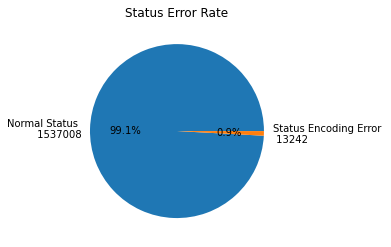

In [8]:
a = df[df['Status'].astype(str).str.isnumeric()] # 정상적인 Status 데이터
b = df[~df['Status'].astype(str).str.isnumeric()] # Status Encoding Error 데이터
ratio = [len(a), len(b)]
labels = [f'Normal Status \n {len(a)}', f'Status Encoding Error \n {len(b)}']
plt.title('Status Error Rate')
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [9]:
df = df[df['Status'].astype(str).str.isnumeric()]
df.Status.unique()

array(['200', '404', '302', '403', '500', '499', '301', '400', '206',
       '405', '304'], dtype=object)

## Timestamp 컬럼을 Day, Hour, Minute, Second로 나눕니다.

In [10]:
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

In [11]:
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes,Day,Hour,Minute,Second
0,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,24,10,0,18
1,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0,24,10,0,18
2,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0,24,10,0,18
3,2020-08-24 10:00:18,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0,24,10,0,18
4,2020-08-24 10:00:19,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0,24,10,0,19


### 총 5일간에 로그 기록이 존재 (24, 25, 26, 27, 28)
- 기록된 로그는 24일이 36938건으로 가장 적고 27일이 471092건으로 가장 많습니다.

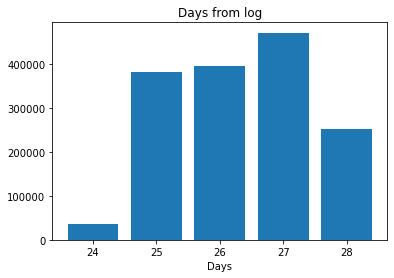

27    471092
26    396362
25    381511
28    251105
24     36938
Name: Day, dtype: int64


In [12]:
x = df['Day'].value_counts().index
y = df['Day'].value_counts()
plt.title('Days from log')
plt.xlabel('Days')
plt.bar(x, y)
plt.show()
print(y)

### 일별 시간(Hours) 로그 분포
- 24일 : 0 ~ 9시 접근기록이 없습니다.
- 25일, 26일, 27일 : 1 ~ 9시 접근기록이 없습니다.
- 28일 : 0 ~ 9시, 20 ~ 24시 접근기록이 없습니다.
- 접근기록이 있는 데이터 중 
    - 24일 20시가 1089건으로 가장 적은 접근이 있었습니다.
    - 27일 14시가 99674건으로 가장 많은 접근이 시도되었습니다.
- 11 ~ 12 부터 14 ~ 15 까지 공격이 진행된 것으로 예상됩니다.

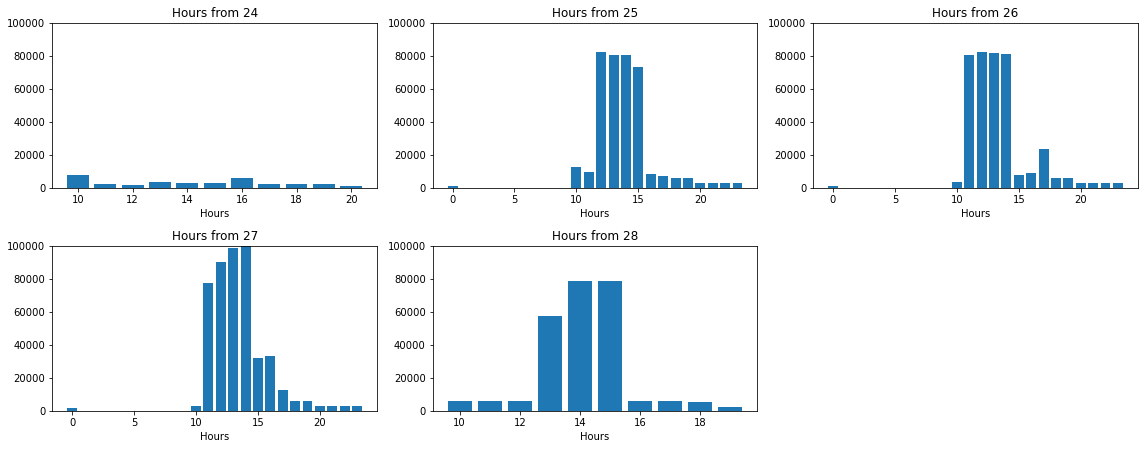

In [13]:
days = df['Day'].unique()
plt.figure(figsize=(16,9))
result = {}
for i in range(5):
    x = df[df['Day'] == days[i] ]['Hour'].value_counts().index
    y = df[df['Day'] == days[i] ]['Hour'].value_counts()
    result[days[i]] = y
    plt.subplot(3, 3, i+1)
    plt.title(f'Hours from {days[i]}')
    plt.xlabel('Hours')
    plt.ylim([0,100000])
    plt.tight_layout()
    plt.bar(x, y)
plt.show()

In [14]:
hour_min_max = {}
for i in result.keys():
    hour_min_max[i] = result[i].min(), result[i].max()

hour_min_max

{24: (1089, 7983),
 25: (1445, 82421),
 26: (1451, 82543),
 27: (1484, 99674),
 28: (2284, 78503)}

# 시나리오#1

### 웹 스크래핑, 크롤러
- 분단위 평균 기록횟수를 훌쩍 넘어가는 특정 시간대를 추출하여 리스팅
- 추출된 특정 시간대에서 사용된 UA 중 특수한 UA가 있는지 추출
- 추출된 특정 시간대에서 일반적인 접속량을 훌쩍 넘기는 Host 추출하여 리스팅
- 추출된 10개 Host의 패턴 분석 (Referer, Path, Bytes, 머무는 시간 등)
- 발견된 패턴대로 다른 Host에 대입하여 웹 스크래핑 입증

In [15]:
df = pd.read_csv('../dataset/track1.csv') # 데이터 프레임 초기화
df.Timestamp = pd.to_datetime(df.Timestamp) 
df = df[df['Status'].astype(str).str.isnumeric()] # 이상치 제거
df['Timestamp'] = df['Timestamp'].dt.strftime('%Y-%m-%d %H:%M') # 시계열 데이터를 1분 단위로 설정
df.head()

,Timestamp,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
0,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-includes/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
1,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-login/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6226.0
2,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-register/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6232.0
3,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6248.0
4,2020-08-24 10:00,GET,HTTP/1.1,200,"""-""",/1000/wp-content/,101.224.32.28,Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv...,-,6224.0


In [206]:
time_grp = df.groupby(['Timestamp'])
time_grp.count()

,Method,Protocol,Status,Referer,Path,Host,UA,Payload,Bytes
Timestamp,,,,,,,,,
2020-08-24 10:00,9,9,9,9,9,9,9,9,9
2020-08-24 10:01,11,11,11,11,11,11,11,11,11
2020-08-24 10:02,28,28,28,28,28,28,28,28,28
2020-08-24 10:03,38,38,38,38,38,38,38,38,38
2020-08-24 10:04,31,31,31,31,31,31,31,31,31
...,...,...,...,...,...,...,...,...,...
2020-08-28 19:42,48,48,48,48,48,48,48,48,48
2020-08-28 19:43,49,49,49,49,49,48,49,49,49
2020-08-28 19:44,54,54,54,54,54,54,54,54,54


In [17]:
times = {}
host = []
for name, group in time_grp.Host:
#     print(name + ' : ' + str(len(group)))
#     print()
    times[name] = int(len(group))

times = pd.DataFrame.from_dict(times, orient='index')
times.describe()

,0
count,3822.000000
mean,402.147567
std,736.033061
min,1.000000
25%,48.000000
50%,95.000000
75%,148.000000
max,3859.000000


<AxesSubplot:>

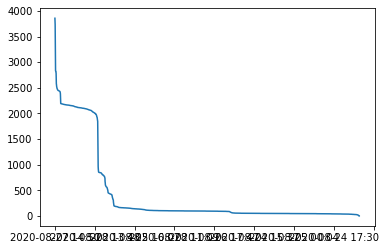

In [21]:
times[0].sort_values(ascending=False).plot()

In [31]:
x = times[0].sort_values(ascending=False).index
y = times[0].sort_values(ascending=False)

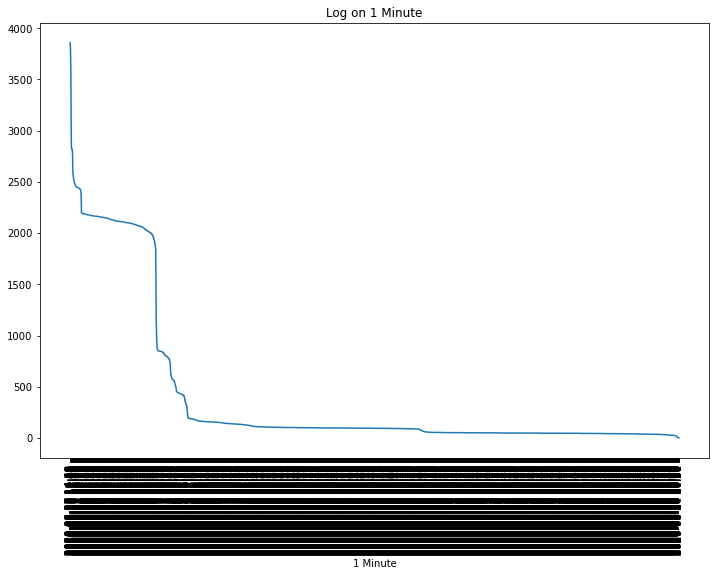

In [33]:
plt.figure(figsize=(12,8))
plt.title('Log on 1 Minute')
plt.plot(x, y)
plt.xlabel('1 Minute')
plt.xticks(rotation=90)
plt.show()

In [212]:
result = {}
time_a = []
time_b = []
time_c = []
host = []
for name, group in time_grp.Host:
    if len(group) > 3000:
        time_a.append(name)
    elif len(group) <= 3000 and len(group) > 1500 :
        time_b.append(name)
    else:
        time_c.append(name)

In [213]:
print(len(time_a))
print(len(time_b))
print(len(time_c))

7
532
3283


In [215]:
532/3822

0.1391941391941392

In [217]:
for i in time_b:
    x = df[df['Timestamp'] == i]['Host'].value_counts().head(10)
    y = len(df[df['Timestamp'] == i]['Host'].value_counts())
    if y < 200:
        print(i)
        print(x)
        print('개별 호스트 유니크 :',y)
        print()

2020-08-24 10:41
101.224.32.28      2921
214.212.159.202       2
150.145.13.106        2
153.65.106.194        2
159.9.54.234          1
37.240.1.87           1
225.28.108.154        1
134.143.196.71        1
160.120.190.111       1
122.210.124.11        1
Name: Host, dtype: int64
개별 호스트 유니크 : 14

2020-08-24 10:42
101.224.32.28      2129
104.112.53.152        2
150.145.13.106        2
220.215.199.145       1
88.18.210.3           1
225.227.252.16        1
46.233.240.230        1
62.110.135.74         1
96.174.152.51         1
37.240.1.87           1
Name: Host, dtype: int64
개별 호스트 유니크 : 19

2020-08-25 10:19
231.211.11.16      2495
6.231.34.180          3
16.48.165.221         2
99.41.195.224         2
80.144.33.236         2
133.162.247.153       2
94.139.60.97          2
160.87.79.158         2
129.214.21.119        1
154.201.115.224       1
Name: Host, dtype: int64
개별 호스트 유니크 : 34

2020-08-26 17:35
112.112.181.134    1761
211.21.181.129        4
244.196.166.240       4
89.249.52.44  